In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import json
import requests
import time

In [7]:
df = pd.read_csv("gambling_sites_dataset.csv")
df = df.sample(frac=1).reset_index(drop=True) # Shuffle

In [8]:
instruction = '''You are a professional gambling site detector.
Analyze the given HTML content and decide: Is it a gambling site?
Output exactly one character:
“1” if the HTML is from a gambling site,
“0” otherwise.

Answer with no explanation, no punctuation, only the digit.'''

print(instruction)

You are a professional gambling site detector.
Analyze the given HTML content and decide: Is it a gambling site?
Output exactly one character:
“1” if the HTML is from a gambling site,
“0” otherwise.

Answer with no explanation, no punctuation, only the digit.


In [ ]:
API_KEY = "YOUR API KEY"
URL = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent"
MAX_RETRIES = 5
TIME_DELAY = 4

headers = {
  "Content-Type": "application/json",
  "X-goog-api-key": API_KEY
}

preds = []
for row in df.itertuples(index=True):

  time.sleep(TIME_DELAY)

  question = f"HTML Content: {row.Scan}\nQuestion: Is it a gambling site?\nAnswer (just answer 0 for no or 1 for yes): "

  prompt = instruction + "\n\n" + question

  payload = {
      "contents": [
      {
        "parts": [
            {
              "text": prompt
            }
        ]
      }
    ]
  }

  retries = 0
  success = False
  while retries < MAX_RETRIES:

    try:
      response = requests.post(URL, headers=headers, data=json.dumps(payload))
      if response.ok:
        json_response = response.json()
        output = json_response["candidates"][0]["content"]["parts"][0]["text"].strip().replace("\n", "")
        print(output, end=" ")
        preds.append(int(output))
        success = True
        break  # Exit the retry loop
      else:
        print(f"Retrying ({retries+1}/{MAX_RETRIES}) - Status code: {response.status_code}")
    
    except Exception as e:
      print(f"Retrying ({retries+1}/{MAX_RETRIES}) - Error: {e}")
        
    retries = retries + 1
    time.sleep(TIME_DELAY)  # Sleep to avoid hitting rate limits

  if not success:
    print("Max retries exceeded, appending default value -1")
    preds.append(-1)  # or use `None`, depending on how you want to handle failure


df["Prediction"] = preds

1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 Retrying (1/5) - Status code: 429
Retrying (2/5) - Status code: 429
0 Retrying (1/5) - Status code: 429
Retrying (2/5) - Status code: 429
0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 Retrying (1/5) - Status code: 429
Retrying (2/5) - Status code: 429
Retrying (3/5) - Status code: 429
1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 Retrying (1/5) - Status code: 429
Retrying (2/5) - Status code: 429
Retrying (3/5) - Status code: 429
Retrying (4/5) - Status code: 429
1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 Retrying (1/5) - Status code: 429
1 Retrying (1/5) - Status code: 429
Retrying (2/5) - Status code: 429
Retrying (3/5) - Status code: 429
1 1 1 1 0 0 0 

In [12]:
true_labels = df["IsGamblingSite"].to_list()
pred_labels = df["Prediction"].to_list()

print(classification_report(true_labels, pred_labels, target_names=['Normal Site', 'Gambling Site']))

               precision    recall  f1-score   support

  Normal Site       0.87      0.97      0.92        40
Gambling Site       0.96      0.81      0.88        31

     accuracy                           0.90        71
    macro avg       0.91      0.89      0.90        71
 weighted avg       0.91      0.90      0.90        71



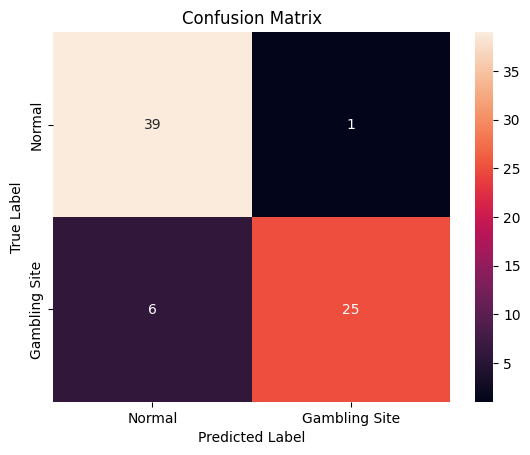

In [13]:
cm = confusion_matrix(true_labels, pred_labels)
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'Gambling Site'], yticklabels=['Normal', 'Gambling Site'])
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()